##**Asssignment2-PART-B-Section3-Creating an End-To-End Dialogue System**

**NAME :** Ganesh Kumaran Masilamani

**STUDENT ID :** 200434339

In [ ]:
#libraries imported
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive")

Mounted at /content/drive


# The Cornell Movie-Dialogs Corpus 

In [ ]:
#Loading the data
lines = open('cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)


Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

In [ ]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [ ]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

max-len of questions for training:  18
max-len of answers for training:  18


In [ ]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data at least 20 times
new_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [ ]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

We are going to create a dataset of pairs without the trimmed words.

In [ ]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [ ]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

 : [------------------->] 100%
Trimmed from 145905 pairs to 114938


114938

In [ ]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

# Embedding layer

In [ ]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding mtrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loded!


#**Seq2Seq Model**



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.



##**Encoder**

#**TASK-1**

**For the first task you need to define a bidirectional GRU and pass the embedding into the GRU.**

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units
        #CODE HERE
        #pass the embedding into a bidirectional version of the GRU
        self.embeddings = embeddings
        #Bidirectional GRU for the encoder
        self.Bidirectional1 = Bidirectional(GRU(enc_units, return_sequences=True, return_state=False, recurrent_initializer='glorot_uniform', name='Encoder_firstGRU'), name='biidirectional_firstEncoder')
        self.Bidirectional2 = Bidirectional(GRU(enc_units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform', name='Encoder_secondGRU'), name='bidirectional_secondEncoder')                                                                                       
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions  

    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        #x = self.dropout(x)
        #x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f,state_b = self.Bidirectional2(x)
        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_len, 50, GRU_units)
print(encoder)

##**Decoder**

#**TASK-2**

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        #CODE HERE
        #Create the decoder with attention
        self.attention = BahdanauAttention(self.units)
        #Unidirectional GRU for the decoder
        self.decoder_gru_l1 = GRU(self.units, return_sequences=True, return_state= False, recurrent_initializer='glorot_uniform' ,name='Decoder_firstGRU')
        self.decoder_gru_l2 = GRU(self.units, return_sequences=False, return_state= True, recurrent_initializer='glorot_uniform' ,name='Decoder_secondGRU') 
        #Dropout layer
        self.dropout = Dropout(0.2)

    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_len, 50, GRU_units)
print(decoder)

# Evaluation

In [ ]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

##Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. 

In [ ]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

##training procedure

##Masked loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


##Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 150 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [ ]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

##Training iterations

Epoch 1 Batch 598 Loss: 2.0916
Epoch 1 Batch 1196 Loss: 2.3373
Epoch 1 Batch 1794 Loss: 2.1438
Epoch 1 Batch 2392 Loss: 2.1444
Epoch 1 Batch 2990 Loss: 1.9260
Epoch 1 Batch 3588 Loss: 2.2786

*** Epoch 1 Loss 2.1012 ***

####################
Greedy| Q: Hello   A: i am not 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  1
Time  200.484 sec

Epoch 2 Batch 598 Loss: 1.7558
Epoch 2 Batch 1196 Loss: 2.3792
Epoch 2 Batch 1794 Loss: 2.3103
Epoch 2 Batch 2392 Loss: 2.3418
Epoch 2 Batch 2990 Loss: 1.7546
Epoch 2 Batch 3588 Loss: 2.1868

*** Epoch 2 Loss 1.8659 ***

####################
Greedy| Q: Hello   A: i am not 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do yo

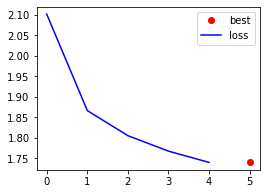

Best epoch so far:  5
Time  175.806 sec

Epoch 6 Batch 598 Loss: 1.5604
Epoch 6 Batch 1196 Loss: 1.8836
Epoch 6 Batch 1794 Loss: 1.7855
Epoch 6 Batch 2392 Loss: 1.9114
Epoch 6 Batch 2990 Loss: 1.6158
Epoch 6 Batch 3588 Loss: 1.9527

*** Epoch 6 Loss 1.7181 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  6
Time  176.458 sec

Epoch 7 Batch 598 Loss: 1.6399
Epoch 7 Batch 1196 Loss: 2.1328
Epoch 7 Batch 1794 Loss: 2.0704
Epoch 7 Batch 2392 Loss: 2.1642
Epoch 7 Batch 2990 Loss: 1.5155
Epoch 7 Batch 3588 Loss: 1.9724

*** Epoch 7 Loss 1.7015 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?

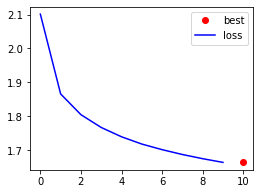

Best epoch so far:  10
Time  174.382 sec

Epoch 11 Batch 598 Loss: 1.4940
Epoch 11 Batch 1196 Loss: 1.8415
Epoch 11 Batch 1794 Loss: 1.6735
Epoch 11 Batch 2392 Loss: 1.8918
Epoch 11 Batch 2990 Loss: 1.5764
Epoch 11 Batch 3588 Loss: 1.9009

*** Epoch 11 Loss 1.6538 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  11
Time  175.743 sec

Epoch 12 Batch 598 Loss: 1.6178
Epoch 12 Batch 1196 Loss: 2.0324
Epoch 12 Batch 1794 Loss: 1.9093
Epoch 12 Batch 2392 Loss: 2.1140
Epoch 12 Batch 2990 Loss: 1.4332
Epoch 12 Batch 3588 Loss: 1.8433

*** Epoch 12 Loss 1.6455 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What

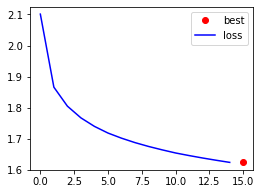

Best epoch so far:  15
Time  176.182 sec

Epoch 16 Batch 598 Loss: 1.4142
Epoch 16 Batch 1196 Loss: 1.8801
Epoch 16 Batch 1794 Loss: 1.6631
Epoch 16 Batch 2392 Loss: 1.9056
Epoch 16 Batch 2990 Loss: 1.5783
Epoch 16 Batch 3588 Loss: 1.7695

*** Epoch 16 Loss 1.6173 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a good idea 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  16
Time  175.979 sec

Epoch 17 Batch 598 Loss: 1.5089
Epoch 17 Batch 1196 Loss: 1.7672
Epoch 17 Batch 1794 Loss: 1.7068
Epoch 17 Batch 2392 Loss: 1.7792
Epoch 17 Batch 2990 Loss: 1.5408
Epoch 17 Batch 3588 Loss: 1.5985

*** Epoch 17 Loss 1.6113 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doi

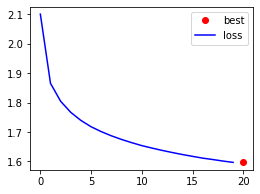

Best epoch so far:  20
Time  176.207 sec

Epoch 21 Batch 598 Loss: 1.3647
Epoch 21 Batch 1196 Loss: 1.9212
Epoch 21 Batch 1794 Loss: 1.7802
Epoch 21 Batch 2392 Loss: 1.9003
Epoch 21 Batch 2990 Loss: 1.5996
Epoch 21 Batch 3588 Loss: 1.8483

*** Epoch 21 Loss 1.5925 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do with you 
####################
check point saved!
Best epoch so far:  21
Time  176.457 sec

Epoch 22 Batch 598 Loss: 1.4575
Epoch 22 Batch 1196 Loss: 1.7599
Epoch 22 Batch 1794 Loss: 1.6557
Epoch 22 Batch 2392 Loss: 1.7998
Epoch 22 Batch 2990 Loss: 1.4665
Epoch 22 Batch 3588 Loss: 1.6432

*** Epoch 22 Loss 1.5880 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Gr

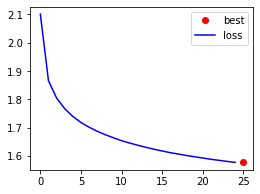

Best epoch so far:  25
Time  176.197 sec

Epoch 26 Batch 598 Loss: 1.3942
Epoch 26 Batch 1196 Loss: 1.9693
Epoch 26 Batch 1794 Loss: 1.8857
Epoch 26 Batch 2392 Loss: 1.8039
Epoch 26 Batch 2990 Loss: 1.6228
Epoch 26 Batch 3588 Loss: 1.9148

*** Epoch 26 Loss 1.5738 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  26
Time  176.908 sec

Epoch 27 Batch 598 Loss: 1.4514
Epoch 27 Batch 1196 Loss: 1.7570
Epoch 27 Batch 1794 Loss: 1.5931
Epoch 27 Batch 2392 Loss: 1.8137
Epoch 27 Batch 2990 Loss: 1.4636
Epoch 27 Batch 3588 Loss: 1.7071

*** Epoch 27 Loss 1.5702 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q

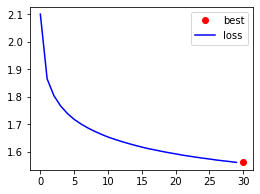

Best epoch so far:  30
Time  175.448 sec

Epoch 31 Batch 598 Loss: 1.2523
Epoch 31 Batch 1196 Loss: 2.0863
Epoch 31 Batch 1794 Loss: 1.8462
Epoch 31 Batch 2392 Loss: 1.9153
Epoch 31 Batch 2990 Loss: 1.5833
Epoch 31 Batch 3588 Loss: 1.9323

*** Epoch 31 Loss 1.5593 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  31
Time  175.695 sec

Epoch 32 Batch 598 Loss: 1.3785
Epoch 32 Batch 1196 Loss: 1.8025
Epoch 32 Batch 1794 Loss: 1.5947
Epoch 32 Batch 2392 Loss: 1.8663
Epoch 32 Batch 2990 Loss: 1.4981
Epoch 32 Batch 3588 Loss: 1.6524

*** Epoch 32 Loss 1.5568 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q:

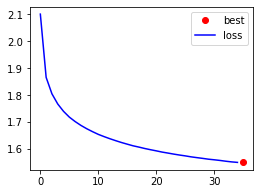

Best epoch so far:  35
Time  175.588 sec

Epoch 36 Batch 598 Loss: 1.3087
Epoch 36 Batch 1196 Loss: 2.1118
Epoch 36 Batch 1794 Loss: 1.8360
Epoch 36 Batch 2392 Loss: 1.9194
Epoch 36 Batch 2990 Loss: 1.5958
Epoch 36 Batch 3588 Loss: 1.8248

*** Epoch 36 Loss 1.5485 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  36
Time  176.680 sec

Epoch 37 Batch 598 Loss: 1.3452
Epoch 37 Batch 1196 Loss: 1.8578
Epoch 37 Batch 1794 Loss: 1.7497
Epoch 37 Batch 2392 Loss: 1.8808
Epoch 37 Batch 2990 Loss: 1.5301
Epoch 37 Batch 3588 Loss: 1.7523

*** Epoch 37 Loss 1.5455 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q:

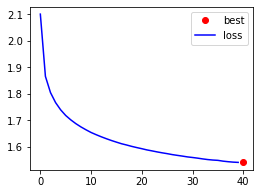

Best epoch so far:  40
Time  177.124 sec

Epoch 41 Batch 598 Loss: 1.3781
Epoch 41 Batch 1196 Loss: 2.0597
Epoch 41 Batch 1794 Loss: 1.9800
Epoch 41 Batch 2392 Loss: 1.8915
Epoch 41 Batch 2990 Loss: 1.5695
Epoch 41 Batch 3588 Loss: 1.8240

*** Epoch 41 Loss 1.5385 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  41
Time  176.546 sec

Epoch 42 Batch 598 Loss: 1.3912
Epoch 42 Batch 1196 Loss: 1.9232
Epoch 42 Batch 1794 Loss: 1.8757
Epoch 42 Batch 2392 Loss: 1.7873
Epoch 42 Batch 2990 Loss: 1.5821
Epoch 42 Batch 3588 Loss: 1.8567

*** Epoch 42 Loss 1.5368 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 

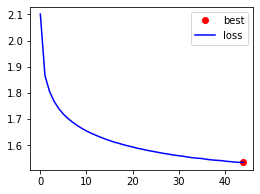

Best epoch so far:  44
Time  176.062 sec

Epoch 46 Batch 598 Loss: 1.4546
Epoch 46 Batch 1196 Loss: 1.9818
Epoch 46 Batch 1794 Loss: 1.9179
Epoch 46 Batch 2392 Loss: 1.8661
Epoch 46 Batch 2990 Loss: 1.5269
Epoch 46 Batch 3588 Loss: 1.8631

*** Epoch 46 Loss 1.5325 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  46
Time  175.574 sec

Epoch 47 Batch 598 Loss: 1.2530
Epoch 47 Batch 1196 Loss: 2.0519
Epoch 47 Batch 1794 Loss: 1.8279
Epoch 47 Batch 2392 Loss: 1.8892
Epoch 47 Batch 2990 Loss: 1.5446
Epoch 47 Batch 3588 Loss: 1.8718

*** Epoch 47 Loss 1.5295 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Gre

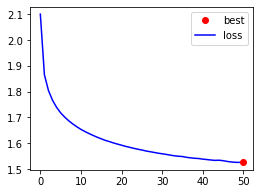

Best epoch so far:  50
Time  176.793 sec

Epoch 51 Batch 598 Loss: 1.4645
Epoch 51 Batch 1196 Loss: 1.9982
Epoch 51 Batch 1794 Loss: 1.9269
Epoch 51 Batch 2392 Loss: 2.0032
Epoch 51 Batch 2990 Loss: 1.5197
Epoch 51 Batch 3588 Loss: 1.9547

*** Epoch 51 Loss 1.5247 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  51
Time  176.604 sec

Epoch 52 Batch 598 Loss: 1.3162
Epoch 52 Batch 1196 Loss: 2.0855
Epoch 52 Batch 1794 Loss: 1.8141
Epoch 52 Batch 2392 Loss: 1.8885
Epoch 52 Batch 2990 Loss: 1.5554
Epoch 52 Batch 3588 Loss: 1.8032

*** Epoch 52 Loss 1.5222 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 

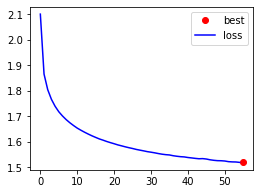

Best epoch so far:  55
Time  176.763 sec

Epoch 56 Batch 598 Loss: 1.4751
Epoch 56 Batch 1196 Loss: 1.9339
Epoch 56 Batch 1794 Loss: 1.9077
Epoch 56 Batch 2392 Loss: 1.9724
Epoch 56 Batch 2990 Loss: 1.5506
Epoch 56 Batch 3588 Loss: 1.8217

*** Epoch 56 Loss 1.5182 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  56
Time  174.025 sec

Epoch 57 Batch 598 Loss: 1.3857
Epoch 57 Batch 1196 Loss: 2.0212
Epoch 57 Batch 1794 Loss: 1.9683
Epoch 57 Batch 2392 Loss: 1.8817
Epoch 57 Batch 2990 Loss: 1.5529
Epoch 57 Batch 3588 Loss: 1.8078

*** Epoch 57 Loss 1.5170 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 

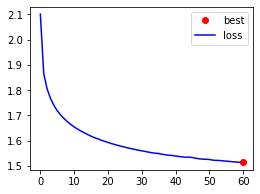

Best epoch so far:  60
Time  175.412 sec

Epoch 61 Batch 598 Loss: 1.4668
Epoch 61 Batch 1196 Loss: 1.8998
Epoch 61 Batch 1794 Loss: 1.8839
Epoch 61 Batch 2392 Loss: 2.0140
Epoch 61 Batch 2990 Loss: 1.5443
Epoch 61 Batch 3588 Loss: 1.8319

*** Epoch 61 Loss 1.5135 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
Best epoch so far:  60
Time  174.000 sec

Epoch 62 Batch 598 Loss: 1.4501
Epoch 62 Batch 1196 Loss: 2.0208
Epoch 62 Batch 1794 Loss: 1.9111
Epoch 62 Batch 2392 Loss: 1.8634
Epoch 62 Batch 2990 Loss: 1.4991
Epoch 62 Batch 3588 Loss: 1.8331

*** Epoch 62 Loss 1.5125 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q

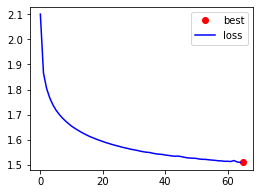

Best epoch so far:  65
Time  177.374 sec

Epoch 66 Batch 598 Loss: 1.4745
Epoch 66 Batch 1196 Loss: 1.7932
Epoch 66 Batch 1794 Loss: 1.9206
Epoch 66 Batch 2392 Loss: 1.9919
Epoch 66 Batch 2990 Loss: 1.4837
Epoch 66 Batch 3588 Loss: 1.7303

*** Epoch 66 Loss 1.5085 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do it 
####################
check point saved!
Best epoch so far:  66
Time  176.361 sec

Epoch 67 Batch 598 Loss: 1.4566
Epoch 67 Batch 1196 Loss: 1.9891
Epoch 67 Batch 1794 Loss: 1.9220
Epoch 67 Batch 2392 Loss: 1.9819
Epoch 67 Batch 2990 Loss: 1.5215
Epoch 67 Batch 3588 Loss: 1.9375

*** Epoch 67 Loss 1.5076 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: What are you doing ?  A:

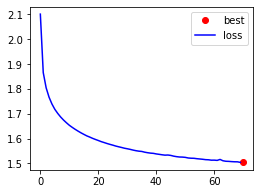

Best epoch so far:  70
Time  175.464 sec

Epoch 71 Batch 598 Loss: 1.4939
Epoch 71 Batch 1196 Loss: 1.8061
Epoch 71 Batch 1794 Loss: 1.8918
Epoch 71 Batch 2392 Loss: 1.9738
Epoch 71 Batch 2990 Loss: 1.3768
Epoch 71 Batch 3588 Loss: 1.7232

*** Epoch 71 Loss 1.5079 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  70
Time  176.217 sec

Epoch 72 Batch 598 Loss: 1.4705
Epoch 72 Batch 1196 Loss: 1.9582
Epoch 72 Batch 1794 Loss: 1.9020
Epoch 72 Batch 2392 Loss: 1.9536
Epoch 72 Batch 2990 Loss: 1.5272
Epoch 72 Batch 3588 Loss: 1.8059

*** Epoch 72 Loss 1.5061 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaura

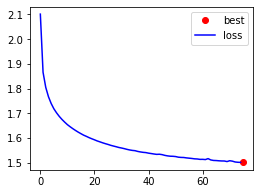

Best epoch so far:  75
Time  176.140 sec

Epoch 76 Batch 598 Loss: 1.5154
Epoch 76 Batch 1196 Loss: 1.8164
Epoch 76 Batch 1794 Loss: 1.8164
Epoch 76 Batch 2392 Loss: 1.9659
Epoch 76 Batch 2990 Loss: 1.3254
Epoch 76 Batch 3588 Loss: 1.6260

*** Epoch 76 Loss 1.5005 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  76
Time  174.521 sec

Epoch 77 Batch 598 Loss: 1.4527
Epoch 77 Batch 1196 Loss: 1.9025
Epoch 77 Batch 1794 Loss: 1.8680
Epoch 77 Batch 2392 Loss: 1.9890
Epoch 77 Batch 2990 Loss: 1.5394
Epoch 77 Batch 3588 Loss: 1.8179

*** Epoch 77 Loss 1.4997 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is you

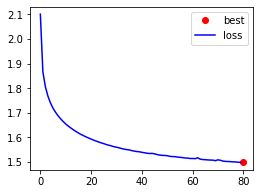

Best epoch so far:  80
Time  176.583 sec

Epoch 81 Batch 598 Loss: 1.4456
Epoch 81 Batch 1196 Loss: 1.7308
Epoch 81 Batch 1794 Loss: 1.5967
Epoch 81 Batch 2392 Loss: 1.7268
Epoch 81 Batch 2990 Loss: 1.4003
Epoch 81 Batch 3588 Loss: 1.4059

*** Epoch 81 Loss 1.4979 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not sure 
####################
Best epoch so far:  80
Time  175.180 sec

Epoch 82 Batch 598 Loss: 1.4657
Epoch 82 Batch 1196 Loss: 1.7838
Epoch 82 Batch 1794 Loss: 1.8974
Epoch 82 Batch 2392 Loss: 1.9808
Epoch 82 Batch 2990 Loss: 1.4619
Epoch 82 Batch 3588 Loss: 1.7317

*** Epoch 82 Loss 1.4980 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite r

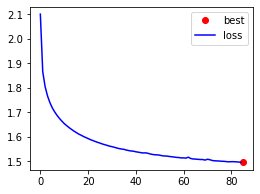

Best epoch so far:  85
Time  177.869 sec

Epoch 86 Batch 598 Loss: 1.3933
Epoch 86 Batch 1196 Loss: 1.7297
Epoch 86 Batch 1794 Loss: 1.5832
Epoch 86 Batch 2392 Loss: 1.7498
Epoch 86 Batch 2990 Loss: 1.3497
Epoch 86 Batch 3588 Loss: 1.4913

*** Epoch 86 Loss 1.4983 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  85
Time  176.309 sec

Epoch 87 Batch 598 Loss: 1.4808
Epoch 87 Batch 1196 Loss: 1.7994
Epoch 87 Batch 1794 Loss: 1.8822
Epoch 87 Batch 2392 Loss: 1.9731
Epoch 87 Batch 2990 Loss: 1.3610
Epoch 87 Batch 3588 Loss: 1.6842

*** Epoch 87 Loss 1.4935 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What is your favorite restaurant ?

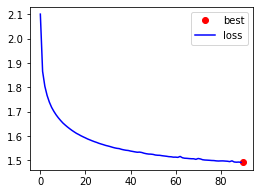

Best epoch so far:  90
Time  175.736 sec

Epoch 91 Batch 598 Loss: 1.4041
Epoch 91 Batch 1196 Loss: 1.6797
Epoch 91 Batch 1794 Loss: 1.5403
Epoch 91 Batch 2392 Loss: 1.7818
Epoch 91 Batch 2990 Loss: 1.3634
Epoch 91 Batch 3588 Loss: 1.5662

*** Epoch 91 Loss 1.4922 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not sure 
####################
Best epoch so far:  90
Time  176.035 sec

Epoch 92 Batch 598 Loss: 1.5044
Epoch 92 Batch 1196 Loss: 1.7775
Epoch 92 Batch 1794 Loss: 1.7987
Epoch 92 Batch 2392 Loss: 1.9592
Epoch 92 Batch 2990 Loss: 1.3154
Epoch 92 Batch 3588 Loss: 1.6123

*** Epoch 92 Loss 1.4905 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite resta

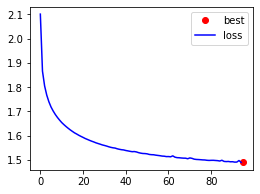

Best epoch so far:  95
Time  175.792 sec

Epoch 96 Batch 598 Loss: 1.3428
Epoch 96 Batch 1196 Loss: 1.7462
Epoch 96 Batch 1794 Loss: 1.5842
Epoch 96 Batch 2392 Loss: 1.8329
Epoch 96 Batch 2990 Loss: 1.4097
Epoch 96 Batch 3588 Loss: 1.5789

*** Epoch 96 Loss 1.4895 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  95
Time  174.731 sec

Epoch 97 Batch 598 Loss: 1.4210
Epoch 97 Batch 1196 Loss: 1.6206
Epoch 97 Batch 1794 Loss: 1.5898
Epoch 97 Batch 2392 Loss: 1.7350
Epoch 97 Batch 2990 Loss: 1.3646
Epoch 97 Batch 3588 Loss: 1.4164

*** Epoch 97 Loss 1.4894 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A:

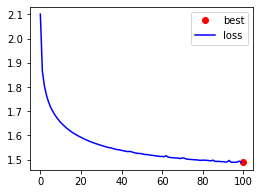

Best epoch so far:  100
Time  175.070 sec

Epoch 101 Batch 598 Loss: 1.3225
Epoch 101 Batch 1196 Loss: 1.8028
Epoch 101 Batch 1794 Loss: 1.7382
Epoch 101 Batch 2392 Loss: 1.8506
Epoch 101 Batch 2990 Loss: 1.4433
Epoch 101 Batch 3588 Loss: 1.7176

*** Epoch 101 Loss 1.4868 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  101
Time  173.956 sec

Epoch 102 Batch 598 Loss: 1.3985
Epoch 102 Batch 1196 Loss: 1.6570
Epoch 102 Batch 1794 Loss: 1.5816
Epoch 102 Batch 2392 Loss: 1.7576
Epoch 102 Batch 2990 Loss: 1.3336
Epoch 102 Batch 3588 Loss: 1.4771

*** Epoch 102 Loss 1.4868 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am

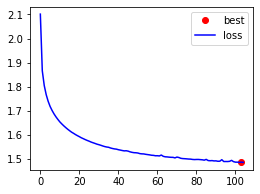

Best epoch so far:  103
Time  176.417 sec

Epoch 106 Batch 598 Loss: 1.3623
Epoch 106 Batch 1196 Loss: 1.8704
Epoch 106 Batch 1794 Loss: 1.8555
Epoch 106 Batch 2392 Loss: 1.7700
Epoch 106 Batch 2990 Loss: 1.5110
Epoch 106 Batch 3588 Loss: 1.7683

*** Epoch 106 Loss 1.4844 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  106
Time  176.788 sec

Epoch 107 Batch 598 Loss: 1.4097
Epoch 107 Batch 1196 Loss: 1.6916
Epoch 107 Batch 1794 Loss: 1.5265
Epoch 107 Batch 2392 Loss: 1.7897
Epoch 107 Batch 2990 Loss: 1.3436
Epoch 107 Batch 3588 Loss: 1.5615

*** Epoch 107 Loss 1.4841 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Gree

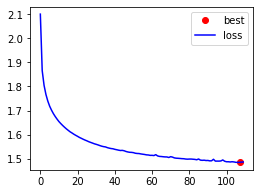

Best epoch so far:  107
Time  176.322 sec

Epoch 111 Batch 598 Loss: 1.2216
Epoch 111 Batch 1196 Loss: 2.0309
Epoch 111 Batch 1794 Loss: 1.8123
Epoch 111 Batch 2392 Loss: 1.8858
Epoch 111 Batch 2990 Loss: 1.5054
Epoch 111 Batch 3588 Loss: 1.8268

*** Epoch 111 Loss 1.4832 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  111
Time  176.163 sec

Epoch 112 Batch 598 Loss: 1.3205
Epoch 112 Batch 1196 Loss: 1.7409
Epoch 112 Batch 1794 Loss: 1.5806
Epoch 112 Batch 2392 Loss: 1.8304
Epoch 112 Batch 2990 Loss: 1.4013
Epoch 112 Batch 3588 Loss: 1.5281

*** Epoch 112 Loss 1.4820 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: Wha

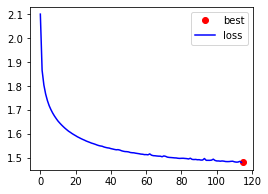

Best epoch so far:  115
Time  176.598 sec

Epoch 116 Batch 598 Loss: 1.2704
Epoch 116 Batch 1196 Loss: 2.0582
Epoch 116 Batch 1794 Loss: 1.8076
Epoch 116 Batch 2392 Loss: 1.8866
Epoch 116 Batch 2990 Loss: 1.5020
Epoch 116 Batch 3588 Loss: 1.7466

*** Epoch 116 Loss 1.4826 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not sure 
####################
Best epoch so far:  115
Time  178.423 sec

Epoch 117 Batch 598 Loss: 1.3183
Epoch 117 Batch 1196 Loss: 1.7993
Epoch 117 Batch 1794 Loss: 1.7259
Epoch 117 Batch 2392 Loss: 1.8452
Epoch 117 Batch 2990 Loss: 1.4613
Epoch 117 Batch 3588 Loss: 1.6740

*** Epoch 117 Loss 1.4813 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is you

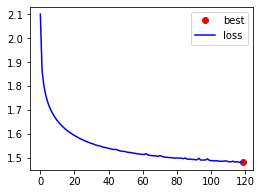

Best epoch so far:  119
Time  174.728 sec

Epoch 121 Batch 598 Loss: 1.3209
Epoch 121 Batch 1196 Loss: 1.9845
Epoch 121 Batch 1794 Loss: 1.9384
Epoch 121 Batch 2392 Loss: 1.8794
Epoch 121 Batch 2990 Loss: 1.5077
Epoch 121 Batch 3588 Loss: 1.7763

*** Epoch 121 Loss 1.4794 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  121
Time  175.430 sec

Epoch 122 Batch 598 Loss: 1.3477
Epoch 122 Batch 1196 Loss: 1.8751
Epoch 122 Batch 1794 Loss: 1.8417
Epoch 122 Batch 2392 Loss: 1.7561
Epoch 122 Batch 2990 Loss: 1.4902
Epoch 122 Batch 3588 Loss: 1.7725

*** Epoch 122 Loss 1.4797 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: Wha

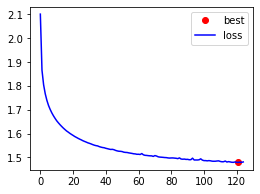

Best epoch so far:  121
Time  177.664 sec

Epoch 126 Batch 598 Loss: 1.3792
Epoch 126 Batch 1196 Loss: 1.9077
Epoch 126 Batch 1794 Loss: 1.9010
Epoch 126 Batch 2392 Loss: 1.8521
Epoch 126 Batch 2990 Loss: 1.4715
Epoch 126 Batch 3588 Loss: 1.8117

*** Epoch 126 Loss 1.4802 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not sure 
####################
Best epoch so far:  121
Time  177.003 sec

Epoch 127 Batch 598 Loss: 1.2273
Epoch 127 Batch 1196 Loss: 2.0088
Epoch 127 Batch 1794 Loss: 1.8166
Epoch 127 Batch 2392 Loss: 1.8776
Epoch 127 Batch 2990 Loss: 1.4785
Epoch 127 Batch 3588 Loss: 1.8013

*** Epoch 127 Loss 1.4818 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is you

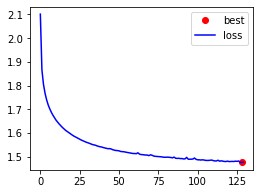

Best epoch so far:  128
Time  176.781 sec

Epoch 131 Batch 598 Loss: 1.3998
Epoch 131 Batch 1196 Loss: 1.9549
Epoch 131 Batch 1794 Loss: 1.8861
Epoch 131 Batch 2392 Loss: 1.9848
Epoch 131 Batch 2990 Loss: 1.4653
Epoch 131 Batch 3588 Loss: 1.9073

*** Epoch 131 Loss 1.4771 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no i am not going to do 
####################
Best epoch so far:  128
Time  176.158 sec

Epoch 132 Batch 598 Loss: 1.2731
Epoch 132 Batch 1196 Loss: 2.0622
Epoch 132 Batch 1794 Loss: 1.8010
Epoch 132 Batch 2392 Loss: 1.8967
Epoch 132 Batch 2990 Loss: 1.5072
Epoch 132 Batch 3588 Loss: 1.7229

*** Epoch 132 Loss 1.4785 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 


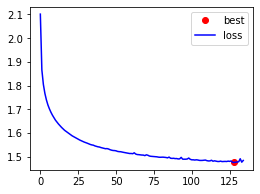

Best epoch so far:  128
Time  176.121 sec

Epoch 136 Batch 598 Loss: 1.3940
Epoch 136 Batch 1196 Loss: 1.9066
Epoch 136 Batch 1794 Loss: 1.8942
Epoch 136 Batch 2392 Loss: 1.9217
Epoch 136 Batch 2990 Loss: 1.4874
Epoch 136 Batch 3588 Loss: 1.7847

*** Epoch 136 Loss 1.4766 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am allergic 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  128
Time  174.263 sec

Epoch 137 Batch 598 Loss: 1.3285
Epoch 137 Batch 1196 Loss: 1.9918
Epoch 137 Batch 1794 Loss: 1.9526
Epoch 137 Batch 2392 Loss: 1.8981
Epoch 137 Batch 2990 Loss: 1.5077
Epoch 137 Batch 3588 Loss: 1.7643

*** Epoch 137 Loss 1.4756 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite r

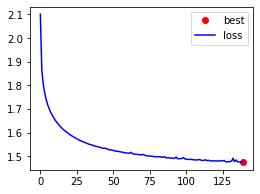

Best epoch so far:  139
Time  173.347 sec

Epoch 141 Batch 598 Loss: 1.3895
Epoch 141 Batch 1196 Loss: 1.8434
Epoch 141 Batch 1794 Loss: 1.8532
Epoch 141 Batch 2392 Loss: 1.9717
Epoch 141 Batch 2990 Loss: 1.5153
Epoch 141 Batch 3588 Loss: 1.7853

*** Epoch 141 Loss 1.4745 ***

####################
Greedy| Q: Hello   A: i am going to see you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  139
Time  172.301 sec

Epoch 142 Batch 598 Loss: 1.3648
Epoch 142 Batch 1196 Loss: 1.9156
Epoch 142 Batch 1794 Loss: 1.8739
Epoch 142 Batch 2392 Loss: 1.8651
Epoch 142 Batch 2990 Loss: 1.4621
Epoch 142 Batch 3588 Loss: 1.7828

*** Epoch 142 Loss 1.4728 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What

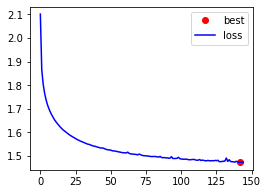

Best epoch so far:  142
Time  171.978 sec

Epoch 146 Batch 598 Loss: 1.4278
Epoch 146 Batch 1196 Loss: 1.7500
Epoch 146 Batch 1794 Loss: 1.8915
Epoch 146 Batch 2392 Loss: 1.9757
Epoch 146 Batch 2990 Loss: 1.4348
Epoch 146 Batch 3588 Loss: 1.7123

*** Epoch 146 Loss 1.4764 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
Best epoch so far:  142
Time  172.297 sec

Epoch 147 Batch 598 Loss: 1.3787
Epoch 147 Batch 1196 Loss: 1.9853
Epoch 147 Batch 1794 Loss: 1.8697
Epoch 147 Batch 2392 Loss: 1.9668
Epoch 147 Batch 2990 Loss: 1.4509
Epoch 147 Batch 3588 Loss: 1.8927

*** Epoch 147 Loss 1.4731 ***

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favo

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [ ]:
checkpoint.restore(str(emb_dim)+"-ckpt-139")

In [ ]:
test_bot()

####################
Greedy| Q: Hello   A: i am sorry 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: no 
####################


Input: how old are you
Predicted answer: i am seventyfour 


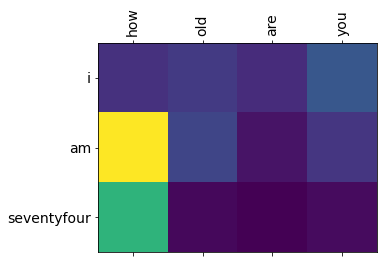

In [ ]:
q = "How old are you"
answer(q, training=False)

Input: do you drink
Predicted answer: i am not going to do 


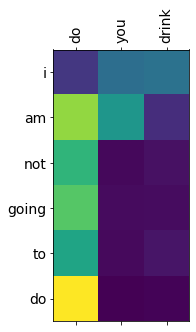

In [ ]:
q = "Do you drink"
answer(q, training=False)

Input: do you watch movie
Predicted answer: no 


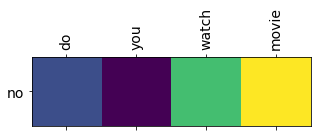

In [ ]:
q = "Do you watch movie"
answer(q, training=False)

Input: how are you
Predicted answer: fine 


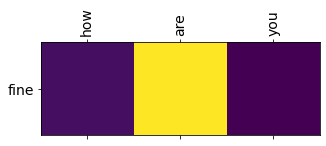

In [ ]:
q = "how are you"
answer(q, training=False)

#**Task-3 (Question-Answering)** 

Let's look at the attention weights and compare them after 5, 50 and 140 epochs. Instead of evaluating by an automatic evaluation method, you can show us 10 predictions for each model. Answer the following question based on your predictions.
##**Epoch 5**
========================================

Epoch 5 Batch 598 Loss: 1.4684

Epoch 5 Batch 1196 Loss: 2.1135

Epoch 5 Batch 1794 Loss: 1.9221

Epoch 5 Batch 2392 Loss: 2.0401

Epoch 5 Batch 2990 Loss: 1.8024

Epoch 5 Batch 3588 Loss: 2.1638

*** Epoch 5 Loss 1.7395 ***

####################

Greedy| Q: Hello   A: hello 

%

Greedy| Q: How are you ?  A: i am not going to do 

%

Greedy| Q: What are you doing ?  A: i am not going to do 

%

Greedy| Q: What is your favorite restaurant ?  A: i am not going to do

%

Greedy| Q: Do you want to go out ?  A: i am not going to do 

####################

check point saved!

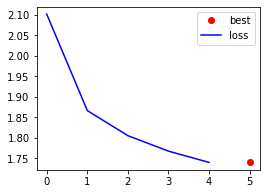

Best epoch so far:  5

Time  175.806 sec

========================================


##**Epoch 50**
========================================
Epoch 50 Batch 598 Loss: 1.4800

Epoch 50 Batch 1196 Loss: 1.8231

Epoch 50 Batch 1794 Loss: 1.9315

Epoch 50 Batch 2392 Loss: 2.0134

Epoch 50 Batch 2990 Loss: 1.4974

Epoch 50 Batch 3588 Loss: 1.7606

*** Epoch 50 Loss 1.5258 ***

####################

Greedy| Q: Hello   A: hello 

%

Greedy| Q: How are you ?  A: i am not 

%

Greedy| Q: What are you doing ?  A: i am not 

%

Greedy| Q: What is your favorite restaurant ?  A: i am not going to do it 

%

Greedy| Q: Do you want to go out ?  A: i am not going to do it 

####################

check point saved!

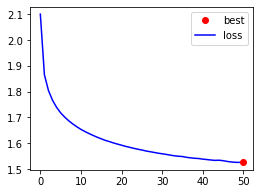

Best epoch so far:  50

Time  176.793 sec

========================================


##**Epoch 140**
========================================

Epoch 140 Batch 598 Loss: 1.4856

Epoch 140 Batch 1196 Loss: 1.7835

Epoch 140 Batch 1794 Loss: 1.8034

Epoch 140 Batch 2392 Loss: 1.9666

Epoch 140 Batch 2990 Loss: 1.2849

Epoch 140 Batch 3588 Loss: 1.6200

*** Epoch 140 Loss 1.4776 ***

####################

Greedy| Q: Hello   A: i am sorry 

%

Greedy| Q: How are you ?  A: fine 

%

Greedy| Q: What are you doing ?  A: i am not 

%

Greedy| Q: What is your favorite restaurant ?  A: i am going to do 

%

Greedy| Q: Do you want to go out ?  A: i am not 
####################

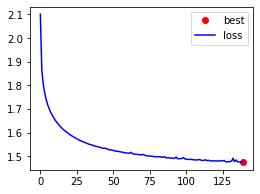

Best epoch so far:  139

Time  173.347 sec

========================================

###**Question-1**

Did the models learn to track local relations between words?

**Answer:**

  Yes, the models learns to track and predict the local relations between the words.

###**Question-2**

Did the models attend to the least frequent tokens in an utterance? Can you see signs of overfitting in models that hang on to the least frequent words?

**Answer:**

   * Yes, the models in an utterance attains the least frequent tokens
   * No, I cannot able to see the signs of overfitting in the models the hang on the least frequent words, since all the models fits good.

###**Question-3**

Did the models learn to track some major syntactic relations in the utterances (subject-verb, verb-object)?

**Answer:**

  Yes, the models actually track major semantic and syntactic relations in the utterances.

###**Question-4**

Do they learn to encode some other linguistic features? Do they capture part-of-speech tags (POS tags)?

**Answer:**

  * Yes, the model learn to encode lingustic features in them.
  * I think they do not capture the POS tags.

###**Question-5**

What is the effect of more training on the length of response?

**Answer:**

* More training on the length of the response will increase the prediction accuracy and the loss will be minimised.
* Greedy Decoding will also gets improved, which gives better results.

###**Question-6**

In some instances, by the time the decoder has to generate the beginning of a response, it may already forget the most relevant early query tokens. Can you suggest ways to change the training pipeline to make it easier for the model to remember the beginning of the query when it starts to generate the response?

**Answer:**

* Batch size is assummed 32 for more stable training.
* Bidirectional GRU is used for the encoder.
* Decoder uses Unidirectional GRU.
* Dropout is assumed with the value 0.2 for both encoder and decoder word embeddings.
* Adam optimizer is used
* Masked Loss is used for the loss generation. The padding inputs of the losses are considered as zero.
* **Instead of passing all the data sequence to the network, This time we have passed timestep of the sequence of a batch data to the convolutional encoder, decoder network.**
* **Early termination could occurs if after performing 1 epoch of training in the training set, loss will be calculated on the development set.**
* **Final development set loss are tracked back, if the dev loss tends to increases, which means that the model is overfitting and the Training will be stopped.**